In [2]:
import tensorflow as tf
import keras
from keras import models
import numpy as np
from keract import get_activations
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.crossover.sbx import SBX
from pymoo.core.problem import Problem, ElementwiseProblem
import random as rng
import pandas as pd
import matplotlib.pyplot as pyplot

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [4]:
input = tf.keras.Input(shape=(32, 32, 3))

efnet = tf.keras.applications.ResNet50(weights='imagenet',
                                             include_top = False, 
                                             input_tensor = input)
# Now that we apply global max pooling.
gap = tf.keras.layers.GlobalMaxPooling2D()(efnet.output)

# Finally, we add a classification layer.
output = tf.keras.layers.Dense(10, activation='softmax', use_bias=True)(gap)

# bind all
func_model = tf.keras.Model(efnet.input, output)

In [5]:
func_model.compile(
          loss  = keras.losses.CategoricalCrossentropy(),
          metrics = keras.metrics.CategoricalAccuracy(),
          optimizer = keras.optimizers.Adam())
# fit 
func_model.fit(x_train, y_train, batch_size=128, epochs=10, verbose = 2)

Epoch 1/10
391/391 - 648s - loss: 1.2547 - categorical_accuracy: 0.6057 - 648s/epoch - 2s/step
Epoch 2/10
391/391 - 738s - loss: 1.1031 - categorical_accuracy: 0.6609 - 738s/epoch - 2s/step
Epoch 3/10
391/391 - 769s - loss: 0.9545 - categorical_accuracy: 0.6872 - 769s/epoch - 2s/step
Epoch 4/10
391/391 - 766s - loss: 0.6207 - categorical_accuracy: 0.7855 - 766s/epoch - 2s/step
Epoch 5/10
391/391 - 729s - loss: 0.4779 - categorical_accuracy: 0.8347 - 729s/epoch - 2s/step
Epoch 6/10
391/391 - 659s - loss: 0.3887 - categorical_accuracy: 0.8661 - 659s/epoch - 2s/step
Epoch 7/10
391/391 - 653s - loss: 0.3316 - categorical_accuracy: 0.8857 - 653s/epoch - 2s/step
Epoch 8/10
391/391 - 653s - loss: 0.5082 - categorical_accuracy: 0.8414 - 653s/epoch - 2s/step
Epoch 9/10
391/391 - 651s - loss: 0.9449 - categorical_accuracy: 0.7006 - 651s/epoch - 2s/step
Epoch 10/10
391/391 - 655s - loss: 0.6558 - categorical_accuracy: 0.7843 - 655s/epoch - 2s/step


In [4]:
# func_model.save('resnet50_cifar10')

model = keras.models.load_model('resnet50_cifar10')

In [5]:
def Neuron_Activation_Coverage(model, input_img):
    
    if len(input_img.shape) < 4:
        input_img = np.expand_dims(input_img, axis=0)

    activations = get_activations(model, input_img, auto_compile=True)
    del activations["input_1"]

    total_nodes = 0
    non_zeros = 0
    for value in activations.values():
        total_nodes += value.size
        non_zeros += np.count_nonzero(value)

    return non_zeros / total_nodes

nac = Neuron_Activation_Coverage(model, x_test[0])

print("NAC: ", nac)

NAC:  0.8558017900159457


In [17]:
class NCMax(ElementwiseProblem):
    def __init__(self, input_img):
        super().__init__(
            n_var=784, n_obj=1, n_constr=0, xl=0, xu=255)
        self.input_img = input_img
    
    def _evaluate(self, x, out, *args, **kwargs):
        x = np.reshape(x, (28, 28, 1))
        x = np.repeat(x, 3, axis=-1)
        x = tf.image.resize(x, [32, 32])
        perturbed_img = self.input_img + x
        nc = Neuron_Activation_Coverage(model, perturbed_img)
        ret_val = 1.0 / nc
        out["F"] = ret_val

alg = NSGA2(pop_size = 30, offsprings=30,
            sampling=FloatRandomSampling(),
            crossovers=SBX(),
            mutation=PolynomialMutation(),)

challenging_images = np.zeros(shape=(10000, 32, 32, 3))

random_indexes = rng.sample(range(0, 10000), 100)

for i in range(0, 1):
    problem = NCMax(x_test[random_indexes[i]])
    
    res = minimize(problem, alg, ("n_gen", 50))
    if res.X.size > 784:
        noise = np.reshape(res.X[0], (28, 28, 1))
        noise = np.repeat(noise, 3, axis=-1)
        noise = tf.image.resize(noise, [32, 32])
    else:
        noise = np.reshape(res.X, (28, 28, 1))
        noise = np.repeat(noise, 3, axis=-1)
        noise = tf.image.resize(noise, [32, 32])

    challenging_img = x_test[random_indexes[i]] + noise
    challenging_images[i] = challenging_img

In [18]:
x_test_nacs = []
challenging_images_nacs = []
absolute_increase = []
relative_increase = []

for i in range(0, 1):
    pre_NSGA = Neuron_Activation_Coverage(model, x_test[random_indexes[i]])
    post_NSGA = Neuron_Activation_Coverage(model, challenging_images[i])
    x_test_nacs.append(pre_NSGA)
    challenging_images_nacs.append(post_NSGA)
    absolute_increase.append(post_NSGA - pre_NSGA)
    relative_increase.append((post_NSGA - pre_NSGA) / pre_NSGA)

dataset = {
    "Normal Images": x_test_nacs,
    "Challenging Images": challenging_images_nacs,
    "Absolute Increase": absolute_increase,
    "Relative Increase": relative_increase
}

table = pd.DataFrame(dataset)

print(table)

# table.index += 1

# table.to_excel("temp.xlsx")

   Normal Images  Challenging Images  Absolute Increase  Relative Increase
0       0.857398            0.851713          -0.005685           -0.00663


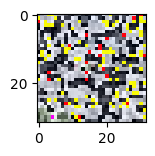

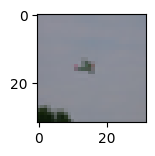

In [19]:
pyplot.subplot(330 + 1)
pyplot.imshow(challenging_images[0].astype('uint8'), cmap=pyplot.get_cmap('gray'))
pyplot.show()

pyplot.subplot(330 + 1)
pyplot.imshow(x_test[random_indexes[0]], cmap=pyplot.get_cmap('gray'))
pyplot.show()